In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFpr, chi2
pd.set_option('display.max_columns',100)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import re
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFpr
pd.set_option('display.max_columns',100)
import optuna
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



In [2]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\Python P\ML\Datasets\Loan_Default.csv")

In [3]:
df.shape

(148670, 34)

In [4]:
df.head()

ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  \
0           p1                l1        nopc                  nob/c   
1           p1                l1        nopc                    b/c   
2           p1                l1        nopc                  nob/c   
3           p4                l1        nopc                  nob/c   
4           p1                l1        nopc                  nob/c   

   loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
0       116500               NaN                   NaN              NaN   
1       206500               NaN                   NaN              NaN   
2       406500              4.56                0.2000            595.0   
3       456500              4.25                0.6810              NaN   
4       696500              4.00                0.3042              0.0   

    term Neg_ammortization interest_only lump_sum_payment  property_value  \
0  360.0           not_neg       not_int         not_lpsm        118000.0   
1  360.0           not_neg       not_int             lpsm             NaN   
2  360.0           neg_amm       not_int         not_lpsm        508000.0   
3  360.0           not_neg       not_int         not_lpsm        658000.0   
4  360.0           not_neg       not_int         not_lpsm        758000.0   

  construction_type occupancy_type Secured_by total_units   income  \
0                sb             pr       home          1U   1740.0   
1                sb             pr       home          1U   4980.0   
2                sb             pr       home          1U   9480.0   
3                sb             pr       home          1U  11880.0   
4                sb             pr       home          1U  10440.0   

  credit_type  Credit_Score co-applicant_credit_type    age  \
0         EXP           758                      CIB  25-34   
1        EQUI           552                      EXP  55-64   
2         EXP           834                      CIB  35-44   
3         EXP           587                      CIB  45-54   
4        CRIF           602                      EXP  25-34   

  submission_of_application        LTV Region Security_Type  Status  dtir1  
0                   to_inst  98.728814  south        direct       1   45.0  
1                   to_inst        NaN  North        direct       1    NaN  
2                   to_inst  80.019685  south        direct       0   46.0  
3                  not_inst  69.376900  North        direct       0   42.0  
4                  not_inst  91.886544  North        direct       0   39.0

# Data Preprocessing

In [5]:
## Missing values

df.isnull().sum()*100/len(df)

ID                            0.000000
year                          0.000000
loan_limit                    2.249277
Gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
Interest_rate_spread         24.644515
Upfront_charges              26.664425
term                          0.027578
Neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
Credit_Score             

In [7]:
df['Status'].value_counts()

0    112031
1     36639
Name: Status, dtype: int64

In [8]:
df['Status'].value_counts() / len(df)

0    0.753555
1    0.246445
Name: Status, dtype: float64

In [9]:
df['loan_limit'].unique()

array(['cf', nan, 'ncf'], dtype=object)

In [10]:
df['loan_limit'].mode()

0    cf
Name: loan_limit, dtype: object

In [11]:
df['loan_limit']= df['loan_limit'].fillna('cf')

In [12]:
df['approv_in_adv'].unique()

array(['nopre', 'pre', nan], dtype=object)

In [13]:
df['approv_in_adv'].mode()

0    nopre
Name: approv_in_adv, dtype: object

In [14]:
df['approv_in_adv']= df['approv_in_adv'].fillna('nopre')

In [15]:
df['loan_purpose'].unique()

array(['p1', 'p4', 'p3', 'p2', nan], dtype=object)

In [16]:
df['loan_purpose'].mode()

0    p3
Name: loan_purpose, dtype: object

In [17]:
df['loan_purpose'] = df['loan_purpose'].fillna('p3')

In [18]:
df.groupby(['loan_purpose']).rate_of_interest.mean()

loan_purpose
p1    4.179727
p2    4.546740
p3    4.174427
p4    3.809253
Name: rate_of_interest, dtype: float64

In [19]:
df['rate_of_interest'][(df['loan_purpose']=='p1') & (df['rate_of_interest'].isnull())] = 4.17
df['rate_of_interest'][(df['loan_purpose']=='p2') & (df['rate_of_interest'].isnull())] = 4.54
df['rate_of_interest'][(df['loan_purpose']=='p3') & (df['rate_of_interest'].isnull())] =4.17
df['rate_of_interest'][(df['loan_purpose']=='p4')  & (df['rate_of_interest'].isnull())] = 3.80

C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\1322835378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_interest'][(df['loan_purpose']=='p1') & (df['rate_of_interest'].isnull())] = 4.17
C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\1322835378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate_of_interest'][(df['loan_purpose']=='p2') & (df['rate_of_interest'].isnull())] = 4.54
C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\1322835378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [20]:
df.groupby(['loan_purpose']).Interest_rate_spread.mean()

loan_purpose
p1    0.508667
p2    0.897141
p3    0.588353
p4    0.231279
Name: Interest_rate_spread, dtype: float64

In [43]:
df['Interest_rate_spread'][(df['loan_purpose']=='p1') & (df['Interest_rate_spread'].isnull())] = 0.50
df['Interest_rate_spread'][(df['loan_purpose']=='p2') & (df['Interest_rate_spread'].isnull())] = 0.89
df['Interest_rate_spread'][(df['loan_purpose']=='p3') & (df['Interest_rate_spread'].isnull())] = 0.58
df['Interest_rate_spread'][(df['loan_purpose']=='p4') & (df['Interest_rate_spread'].isnull())] = 0.23


C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\3827773318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Interest_rate_spread'][(df['loan_purpose']=='p1') & (df['Interest_rate_spread'].isnull())] = 0.50
C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\3827773318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Interest_rate_spread'][(df['loan_purpose']=='p2') & (df['Interest_rate_spread'].isnull())] = 0.89
C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\3827773318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

In [21]:
df.groupby(['loan_purpose']).Upfront_charges.mean()

loan_purpose
p1    2649.507587
p2    2903.352704
p3    4243.469355
p4    2583.664677
Name: Upfront_charges, dtype: float64

In [22]:
df['Upfront_charges'][(df['loan_purpose']=='p1') & (df['Upfront_charges'].isnull())] = 2649
df['Upfront_charges'][(df['loan_purpose']=='p2') & (df['Upfront_charges'].isnull())] = 2903
df['Upfront_charges'][(df['loan_purpose']=='p3') & (df['Upfront_charges'].isnull())] = 4243
df['Upfront_charges'][(df['loan_purpose']=='p4') & (df['Upfront_charges'].isnull())] = 2583


C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\4270245419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upfront_charges'][(df['loan_purpose']=='p1') & (df['Upfront_charges'].isnull())] = 2649
C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\4270245419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upfront_charges'][(df['loan_purpose']=='p2') & (df['Upfront_charges'].isnull())] = 2903
C:\Users\Dell\AppData\Local\Temp\ipykernel_7796\4270245419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [23]:
df['term'].unique()

array([360., 300., 180., 312., 144., 240., 348., 324., 120.,  96., 192.,
       156., 228., 336., 288., 108., 276.,  nan, 132., 216., 168., 204.,
       264., 252., 165., 280., 322.])

In [24]:
df['term'].mode()

0    360.0
Name: term, dtype: float64

In [25]:
df['term'] = df['term'].fillna(360)

In [26]:
df['income'].median()

5760.0

In [27]:
df['income'] = df['income'].fillna(5760)

In [28]:
df.groupby(['loan_purpose']).property_value.mean()

loan_purpose
p1    415083.665603
p2    499199.727335
p3    481629.057489
p4    565100.724667
Name: property_value, dtype: float64

In [29]:
df['income'].mean()

6883.647810587207

In [30]:
df['property_value'] =df['property_value'].fillna(df['property_value'].mean())

In [31]:
mv  = df.isnull().sum()*100/len(df)
mv[mv>0]

Interest_rate_spread         24.644515
Neg_ammortization             0.081388
age                           0.134526
submission_of_application     0.134526
LTV                          10.155378
dtir1                        16.224524
dtype: float64

In [32]:
df['LTV'] = df['LTV'].fillna(80)

In [33]:
df['dtir1'].median()

39.0

In [34]:
df['dtir1'] = df['dtir1'].fillna(40)

In [35]:
mv  = df.isnull().sum()*100/len(df)
mv[mv>0]

Interest_rate_spread         24.644515
Neg_ammortization             0.081388
age                           0.134526
submission_of_application     0.134526
dtype: float64

In [36]:
df['submission_of_application'].unique()

array(['to_inst', 'not_inst', nan], dtype=object)

In [37]:
df['submission_of_application'] = df['submission_of_application'].fillna('not_inst')

In [38]:
df['age'].mode()

0    45-54
Name: age, dtype: object

In [39]:
df['age'] = df['age'].fillna('45-54')

In [40]:
df['Neg_ammortization'].mode()

0    not_neg
Name: Neg_ammortization, dtype: object

In [41]:
df['Neg_ammortization'] = df['Neg_ammortization'].fillna('not_neg')

In [44]:
mv  = df.isnull().sum()*100/len(df)
mv[mv>0]

Series([], dtype: float64)

In [45]:
df

ID  year loan_limit             Gender approv_in_adv loan_type  \
0        24890  2019         cf  Sex Not Available         nopre     type1   
1        24891  2019         cf               Male         nopre     type2   
2        24892  2019         cf               Male           pre     type1   
3        24893  2019         cf               Male         nopre     type1   
4        24894  2019         cf              Joint           pre     type1   
...        ...   ...        ...                ...           ...       ...   
148665  173555  2019         cf  Sex Not Available         nopre     type1   
148666  173556  2019         cf               Male         nopre     type1   
148667  173557  2019         cf               Male         nopre     type1   
148668  173558  2019         cf             Female         nopre     type1   
148669  173559  2019         cf             Female         nopre     type1   

       loan_purpose Credit_Worthiness open_credit business_or_commercial  \
0                p1                l1        nopc                  nob/c   
1                p1                l1        nopc                    b/c   
2                p1                l1        nopc                  nob/c   
3                p4                l1        nopc                  nob/c   
4                p1                l1        nopc                  nob/c   
...             ...               ...         ...                    ...   
148665           p3                l1        nopc                  nob/c   
148666           p1                l1        nopc                  nob/c   
148667           p4                l1        nopc                  nob/c   
148668           p4                l1        nopc                  nob/c   
148669           p3                l1        nopc                  nob/c   

        loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
0            116500             4.170                0.5000          2649.00   
1            206500             4.170                0.5000          2649.00   
2            406500             4.560                0.2000           595.00   
3            456500             4.250                0.6810          2583.00   
4            696500             4.000                0.3042             0.00   
...             ...               ...                   ...              ...   
148665       436500             3.125                0.2571          9960.00   
148666       586500             5.190                0.8544             0.00   
148667       446500             3.125                0.0816          1226.64   
148668       196500             3.500                0.5824          4323.33   
148669       406500             4.375                1.3871          6000.00   

         term Neg_ammortization interest_only lump_sum_payment  \
0       360.0           not_neg       not_int         not_lpsm   
1       360.0           not_neg       not_int             lpsm   
2       360.0           neg_amm       not_int         not_lpsm   
3       360.0           not_neg       not_int         not_lpsm   
4       360.0           not_neg       not_int         not_lpsm   
...       ...               ...           ...              ...   
148665  180.0           not_neg       not_int         not_lpsm   
148666  360.0           not_neg       not_int         not_lpsm   
148667  180.0           not_neg       not_int         not_lpsm   
148668  180.0           not_neg       not_int         not_lpsm   
148669  240.0           not_neg       not_int         not_lpsm   

        property_value construction_type occupancy_type Secured_by  \
0        118000.000000                sb             pr       home   
1        497893.465696                sb             pr       home   
2        508000.000000                sb             pr       home   
3        658000.000000                sb             pr       home   
4        758000.000000                sb             pr   

In [46]:
## Object Columns

for col in df.select_dtypes('O').columns:
    print(f'{col} : {df[col].nunique()}')

loan_limit : 2
Gender : 4
approv_in_adv : 2
loan_type : 3
loan_purpose : 4
Credit_Worthiness : 2
open_credit : 2
business_or_commercial : 2
Neg_ammortization : 2
interest_only : 2
lump_sum_payment : 2
construction_type : 2
occupancy_type : 3
Secured_by : 2
total_units : 4
credit_type : 4
co-applicant_credit_type : 2
age : 7
submission_of_application : 2
Region : 4
Security_Type : 2


In [52]:
df.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

In [ ]:
df.drop('ID',inplace=True,axis=1)

In [87]:
df.drop('year',inplace=True,axis=1)

# EDA

In [88]:
df.head()

loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0         cf  Sex Not Available         nopre     type1           p1   
1         cf               Male         nopre     type2           p1   
2         cf               Male           pre     type1           p1   
3         cf               Male         nopre     type1           p4   
4         cf              Joint           pre     type1           p1   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  \
0                l1        nopc                  nob/c       116500   
1                l1        nopc                    b/c       206500   
2                l1        nopc                  nob/c       406500   
3                l1        nopc                  nob/c       456500   
4                l1        nopc                  nob/c       696500   

   rate_of_interest  Interest_rate_spread  Upfront_charges   term  \
0              4.17                0.5000           2649.0  360.0   
1              4.17                0.5000           2649.0  360.0   
2              4.56                0.2000            595.0  360.0   
3              4.25                0.6810           2583.0  360.0   
4              4.00                0.3042              0.0  360.0   

  Neg_ammortization interest_only lump_sum_payment  property_value  \
0           not_neg       not_int         not_lpsm   118000.000000   
1           not_neg       not_int             lpsm   497893.465696   
2           neg_amm       not_int         not_lpsm   508000.000000   
3           not_neg       not_int         not_lpsm   658000.000000   
4           not_neg       not_int         not_lpsm   758000.000000   

  construction_type occupancy_type Secured_by total_units   income  \
0                sb             pr       home          1U   1740.0   
1                sb             pr       home          1U   4980.0   
2                sb             pr       home          1U   9480.0   
3                sb             pr       home          1U  11880.0   
4                sb             pr       home          1U  10440.0   

  credit_type  Credit_Score co-applicant_credit_type    age  \
0         EXP           758                      CIB  25-34   
1        EQUI           552                      EXP  55-64   
2         EXP           834                      CIB  35-44   
3         EXP           587                      CIB  45-54   
4        CRIF           602                      EXP  25-34   

  submission_of_application        LTV Region Security_Type  Status  dtir1  
0                   to_inst  98.728814  south        direct       1   45.0  
1                   to_inst  80.000000  North        direct       1   40.0  
2                   to_inst  80.019685  south        direct       0   46.0  
3                  not_inst  69.376900  North        direct       0   42.0  
4                  not_inst  91.886544  North        direct       0   39.0

<AxesSubplot:xlabel='loan_purpose', ylabel='rate_of_interest'>

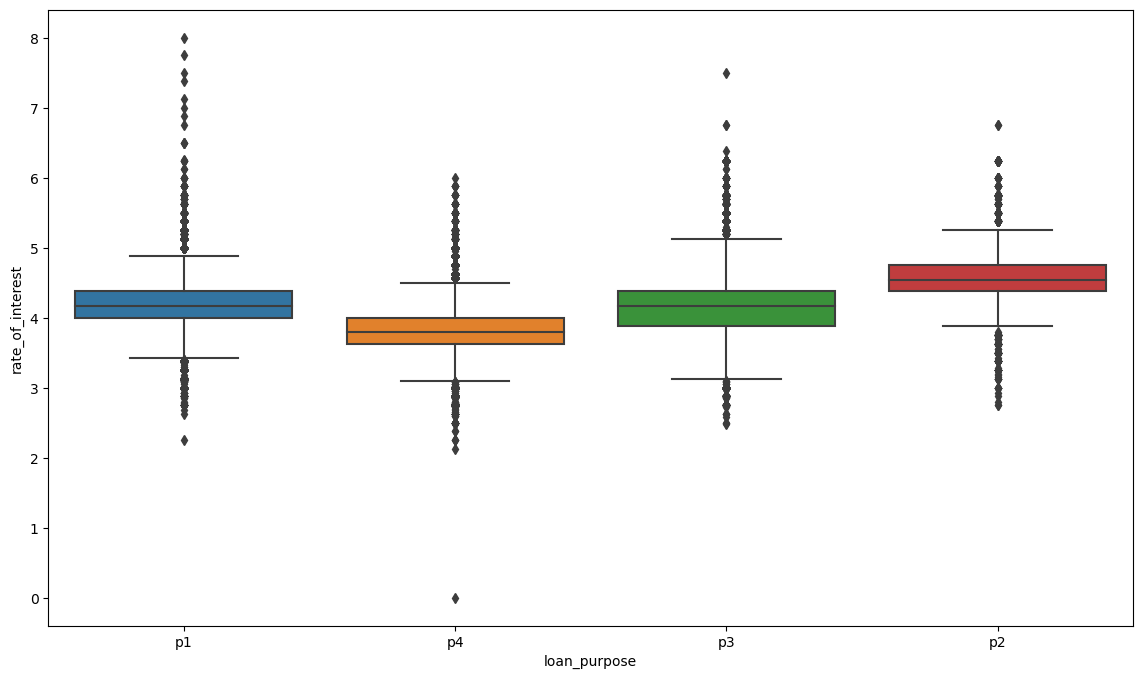

In [49]:
sns.boxplot(x='loan_purpose',y='rate_of_interest',data=df)

<AxesSubplot:xlabel='Credit_Score', ylabel='rate_of_interest'>

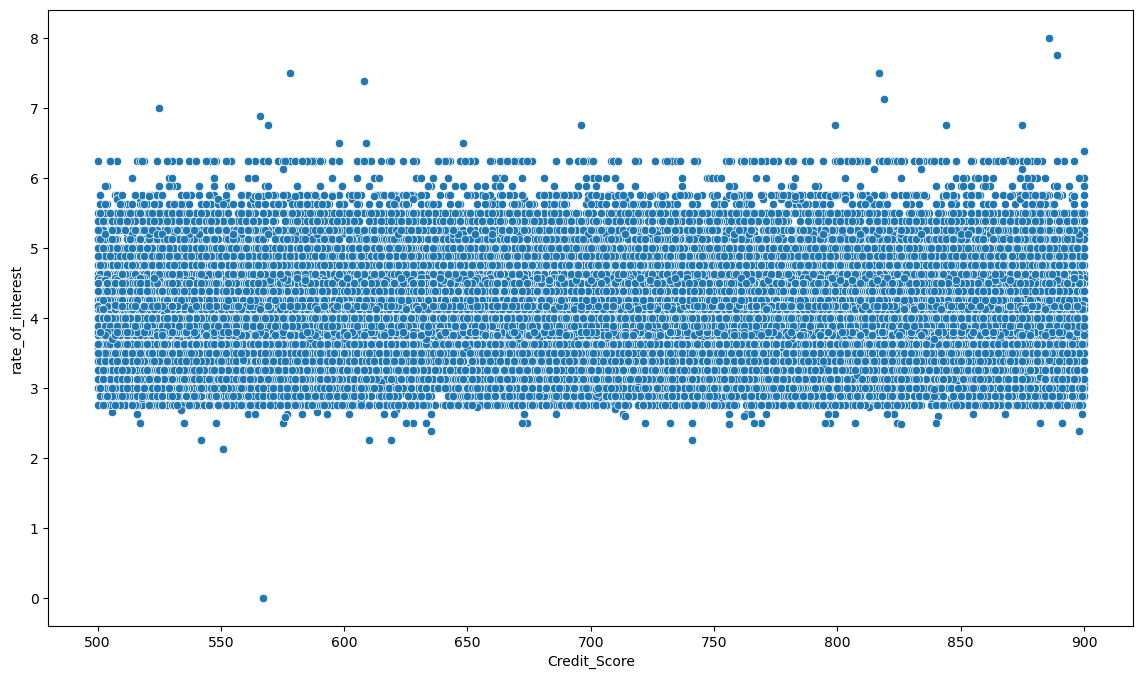

In [50]:
sns.scatterplot(x=df['Credit_Score'], y=df['rate_of_interest'])

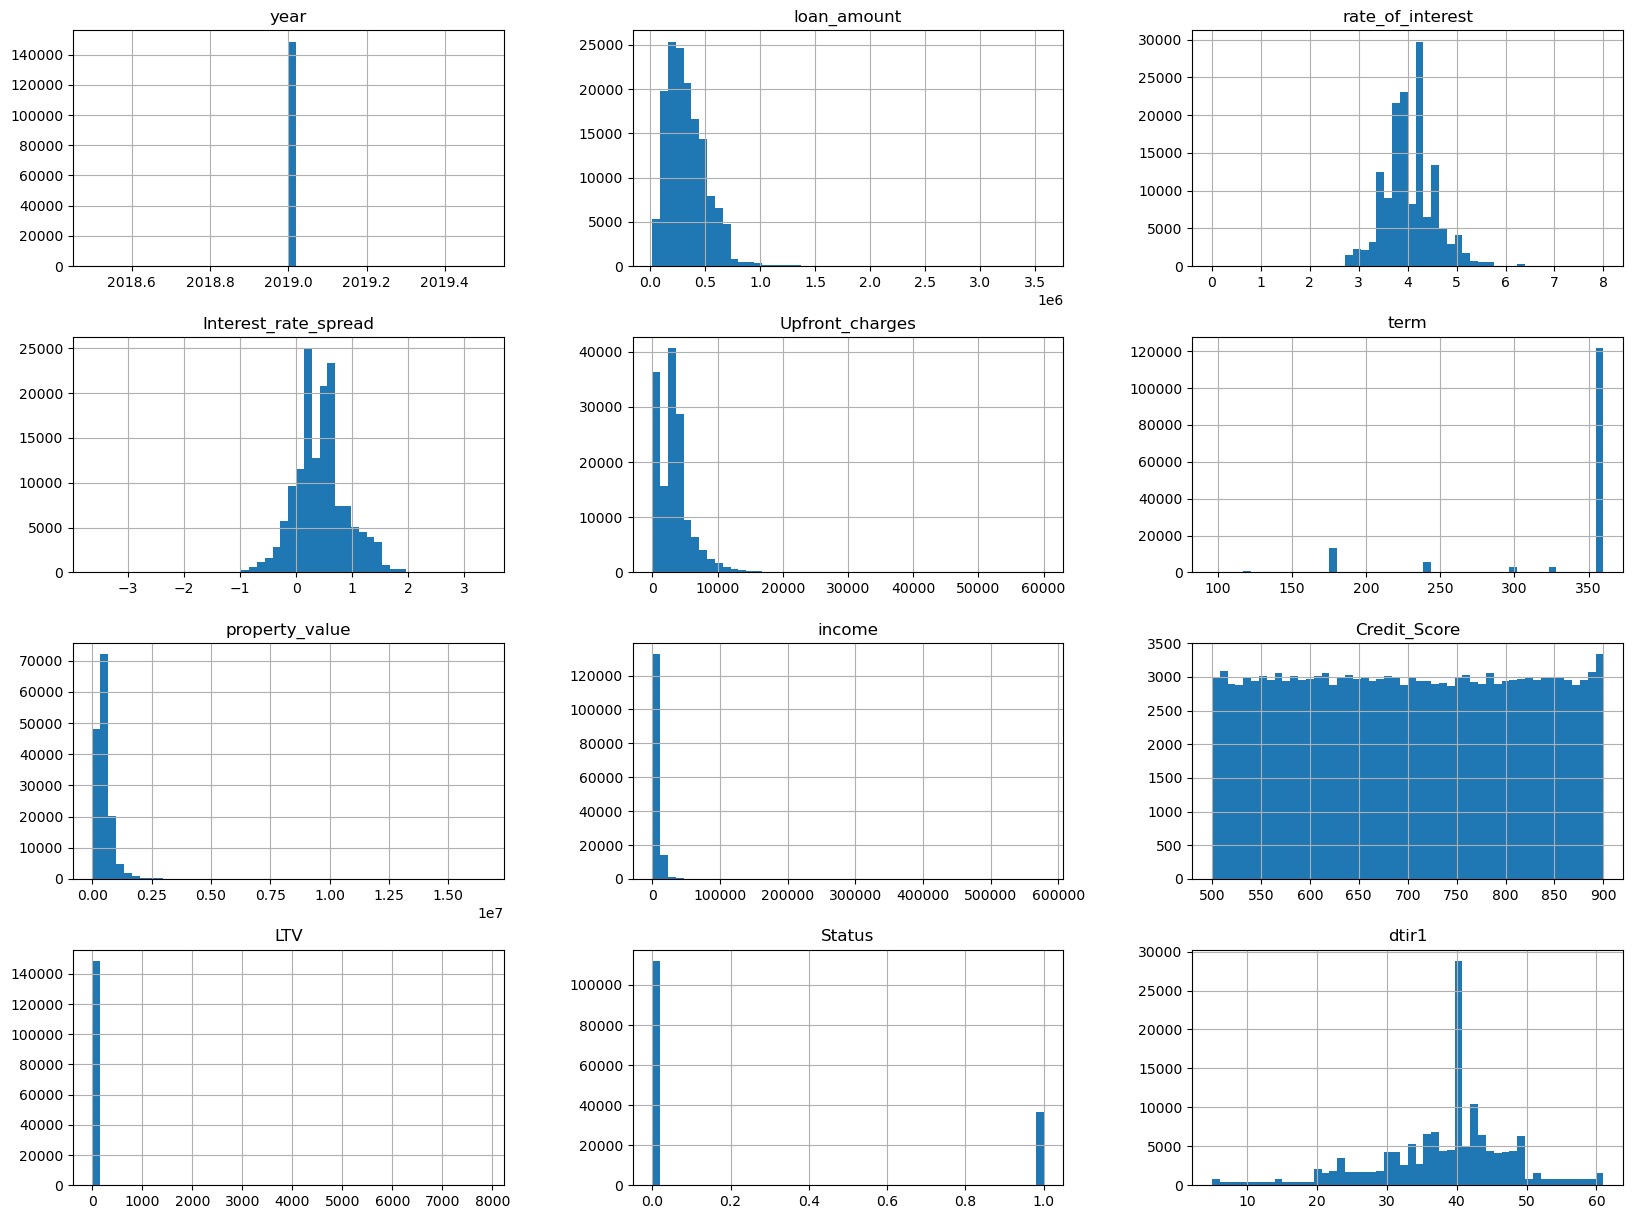

In [51]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [52]:
## Understanding the class distribution

df['Status'].value_counts()

0    112031
1     36639
Name: Status, dtype: int64

In [54]:
df['Status'].value_counts() / len(df)

0    0.753555
1    0.246445
Name: Status, dtype: float64

<AxesSubplot:xlabel='Status', ylabel='count'>

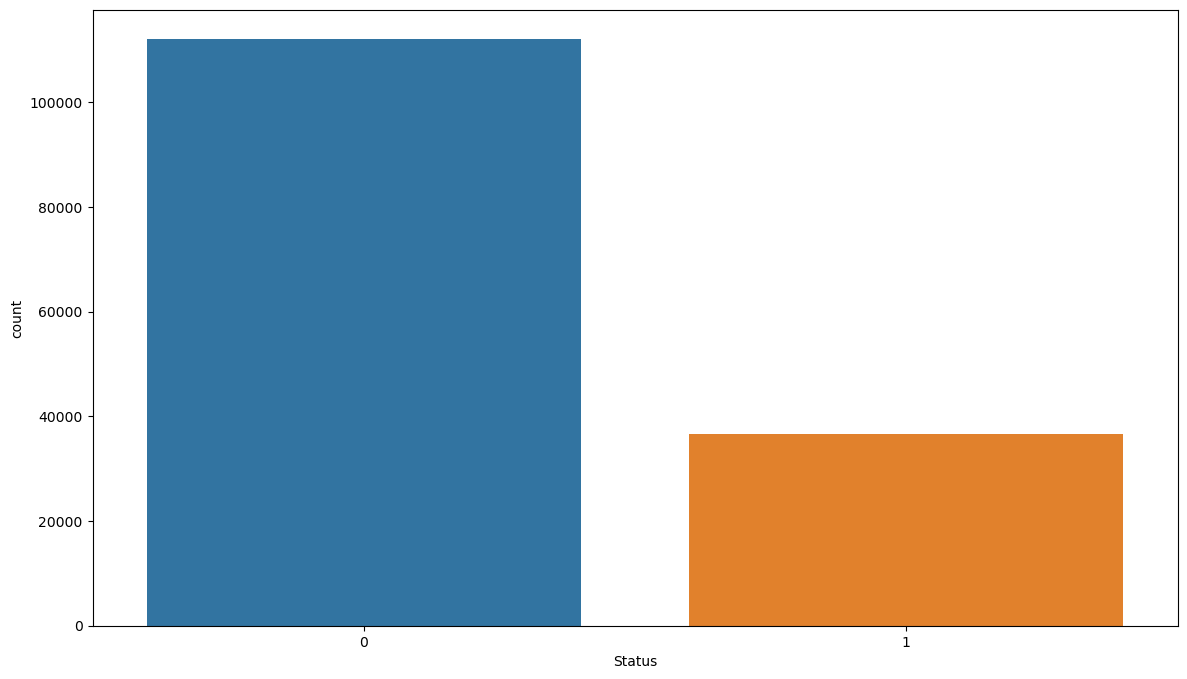

In [55]:
sns.countplot(x='Status',data=df)

<AxesSubplot:xlabel='Gender', ylabel='loan_amount'>

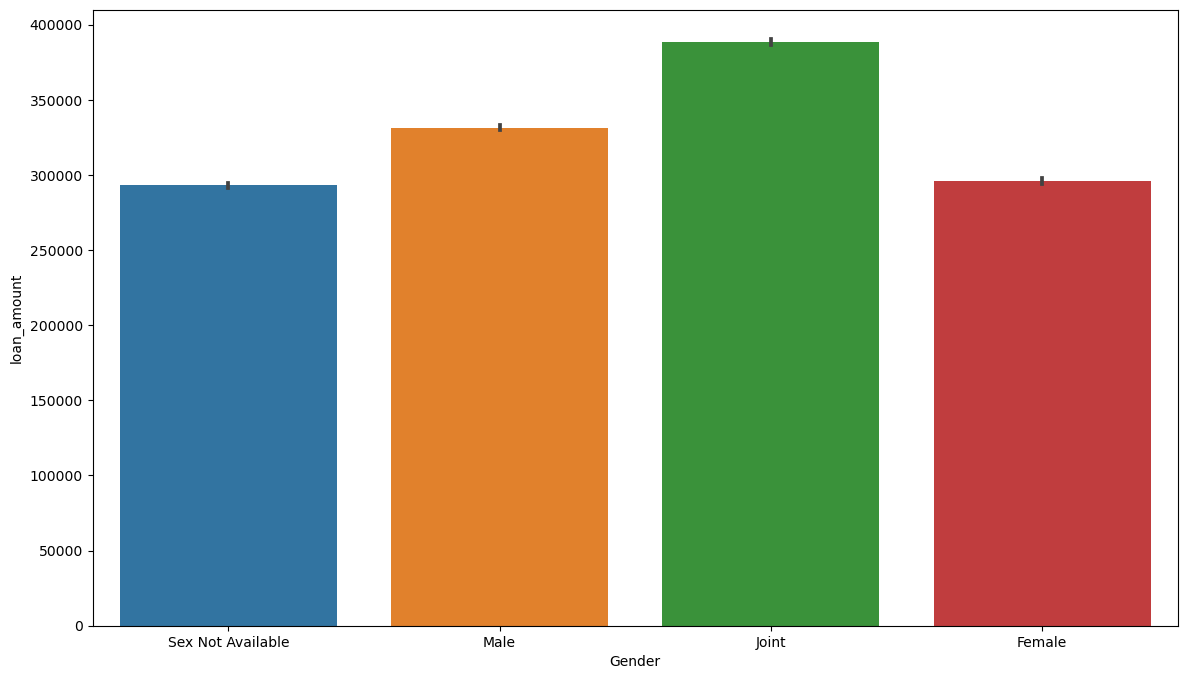

In [57]:
sns.barplot(x='Gender',y='loan_amount',data=df)

<AxesSubplot:xlabel='Gender', ylabel='loan_amount'>

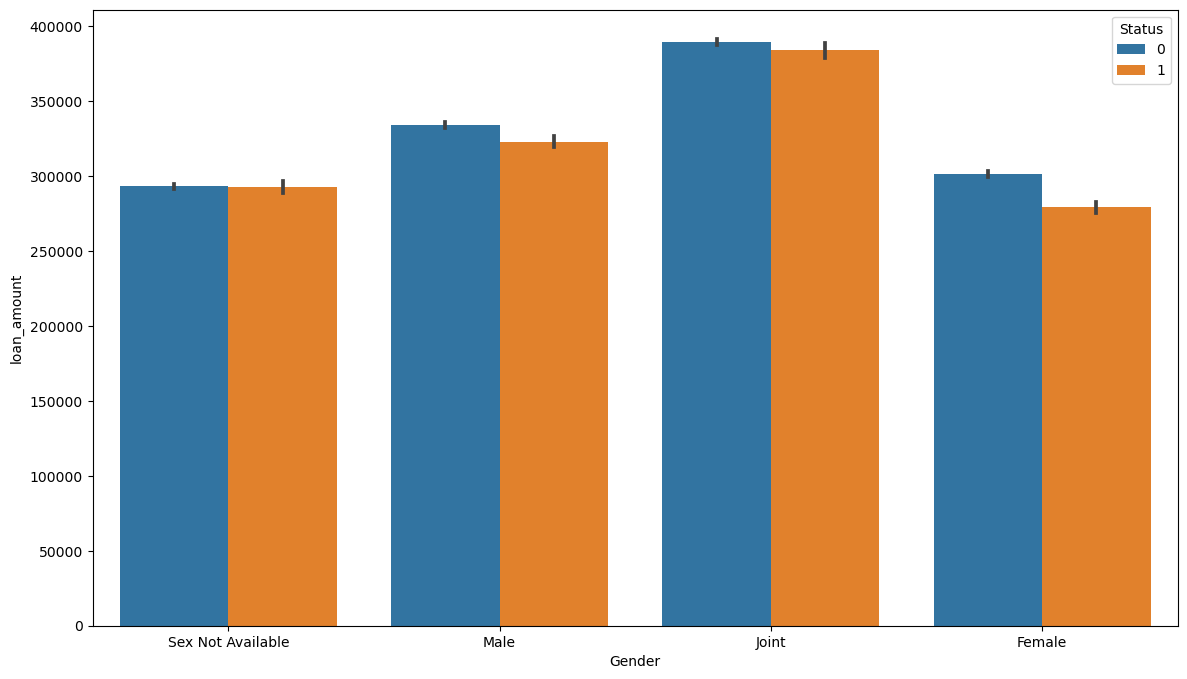

In [58]:
sns.barplot(x='Gender',y='loan_amount',data=df,hue='Status')

In [ ]:
sns.barplot(x='Gender',y='loan_amount',data=df,hue='Status')

<AxesSubplot:xlabel='loan_type', ylabel='count'>

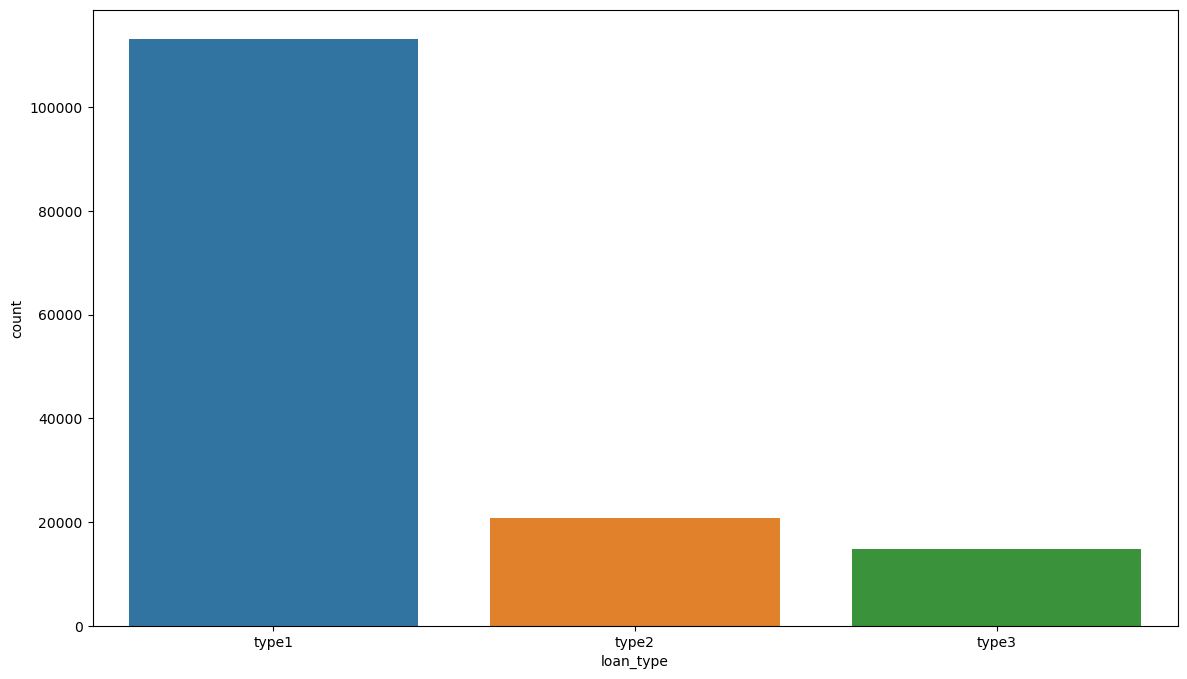

In [61]:
sns.countplot(x='loan_type',data=df)

<AxesSubplot:xlabel='loan_type', ylabel='count'>

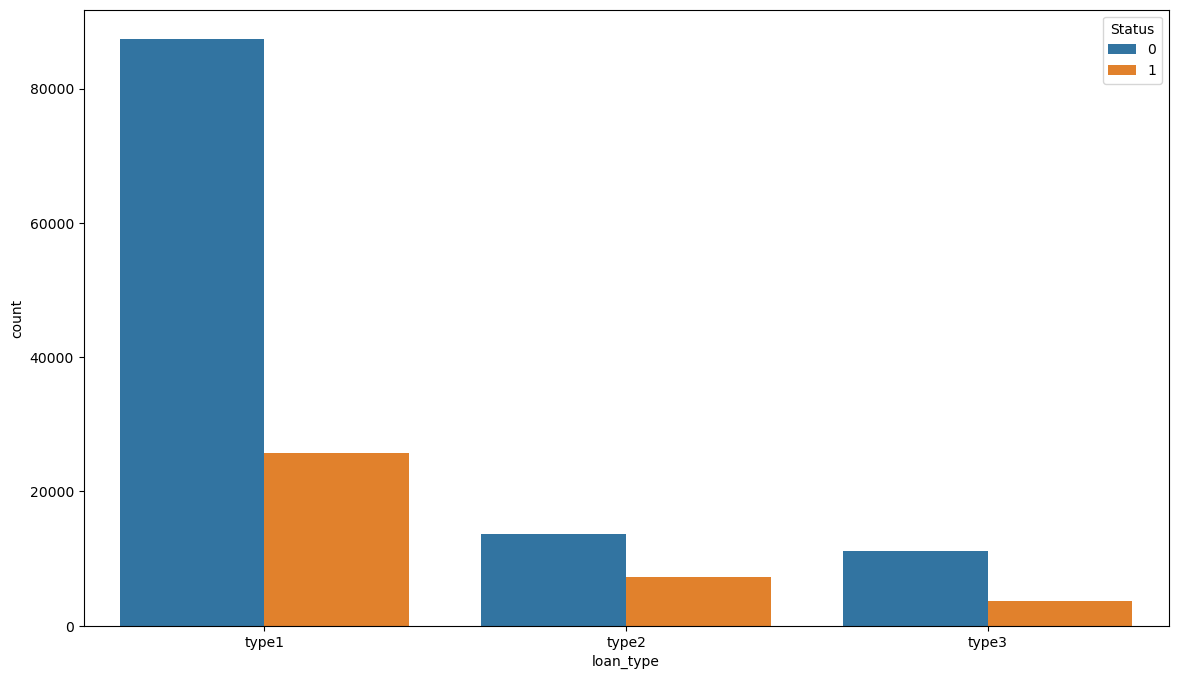

In [62]:
sns.countplot(x='loan_type',data=df,hue='Status')

<AxesSubplot:xlabel='loan_type', ylabel='loan_amount'>

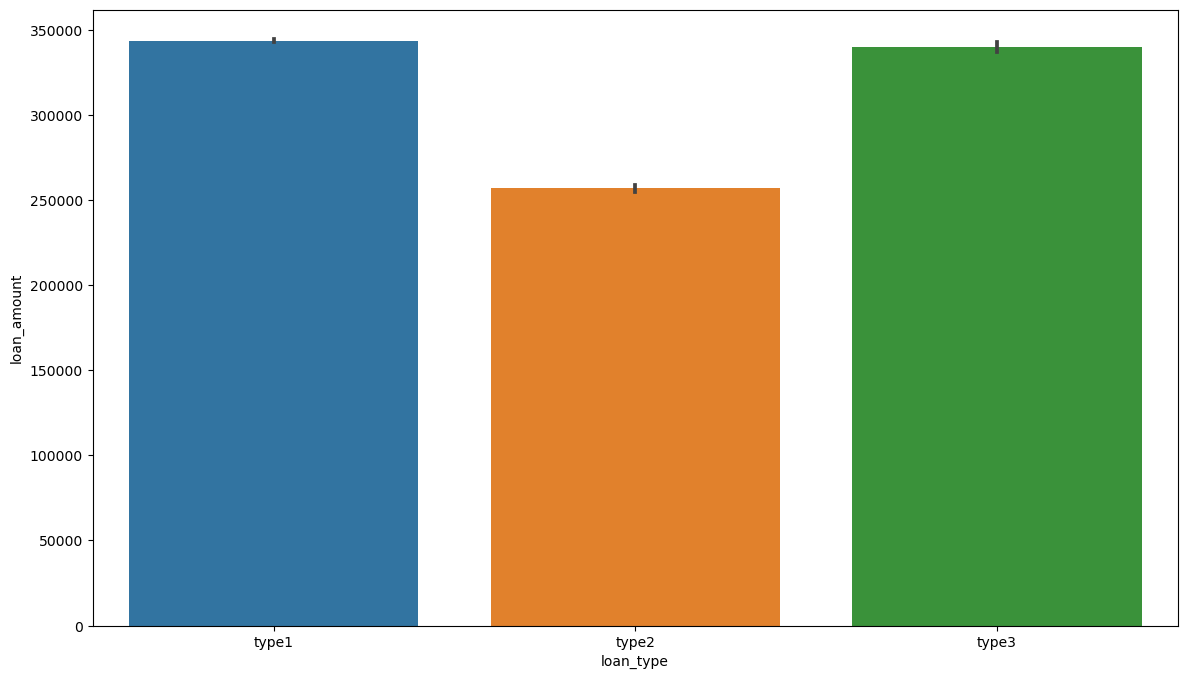

In [63]:
sns.barplot(x='loan_type',y='loan_amount',data=df)

<AxesSubplot:xlabel='loan_type', ylabel='loan_amount'>

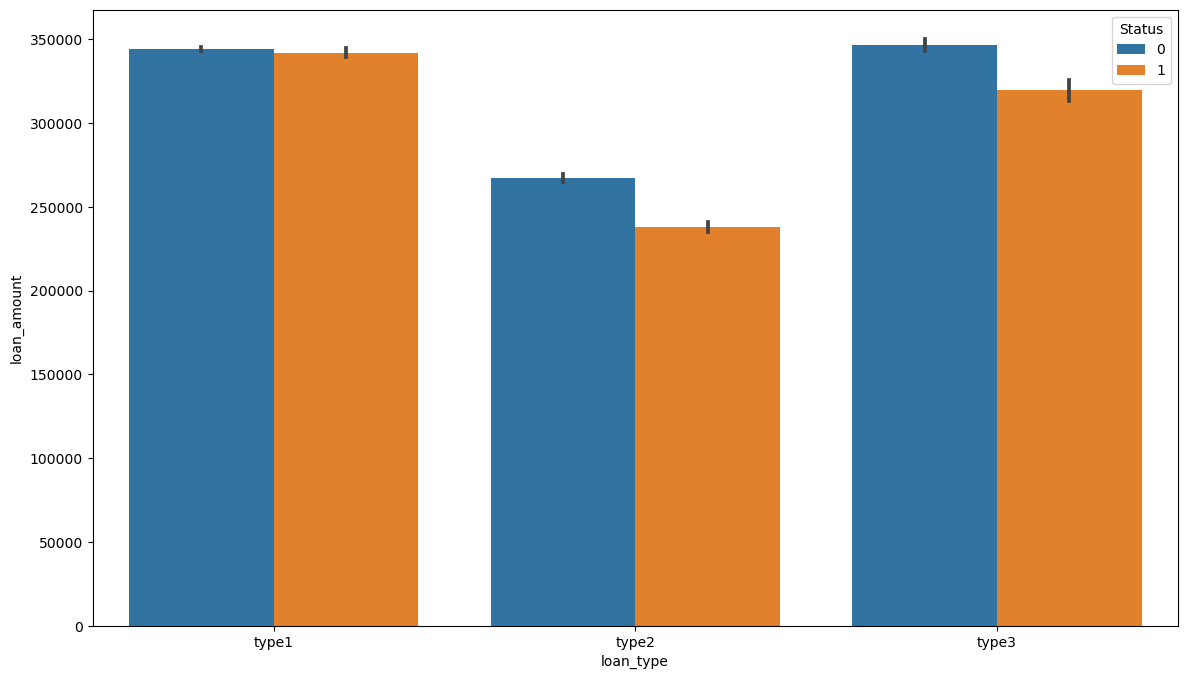

In [65]:
sns.barplot(x='loan_type',y='loan_amount',data=df,hue='Status')

<AxesSubplot:xlabel='Status', ylabel='loan_amount'>

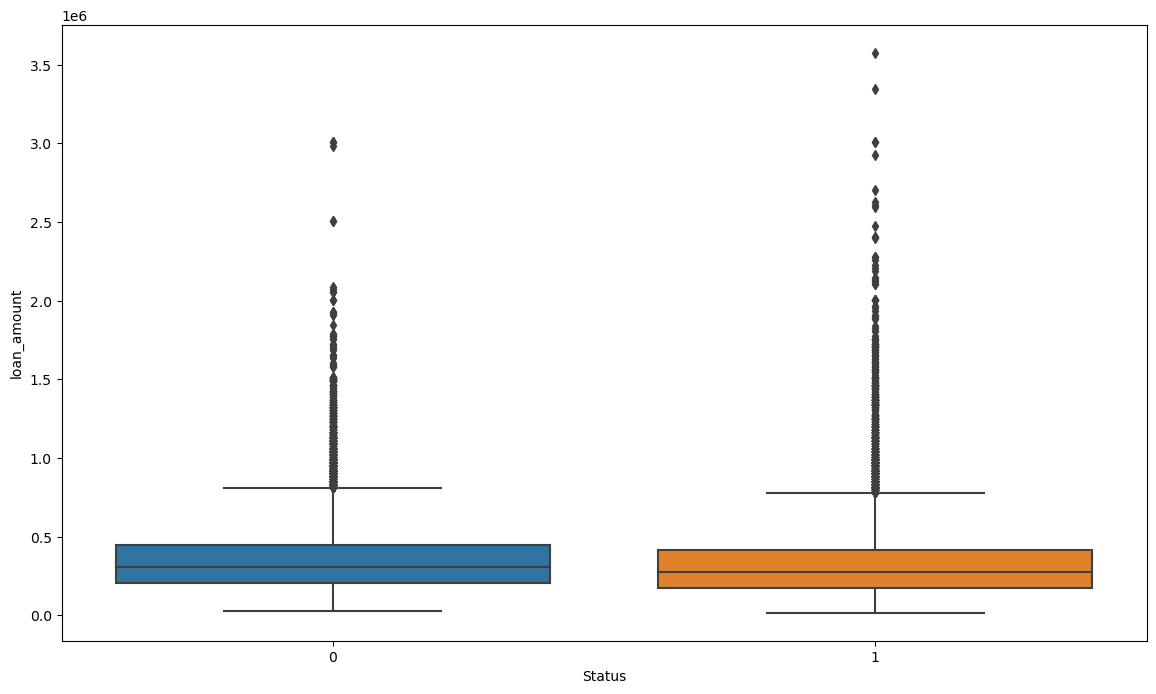

In [66]:
sns.boxplot(y='loan_amount',x='Status',data=df)

<AxesSubplot:xlabel='loan_purpose', ylabel='count'>

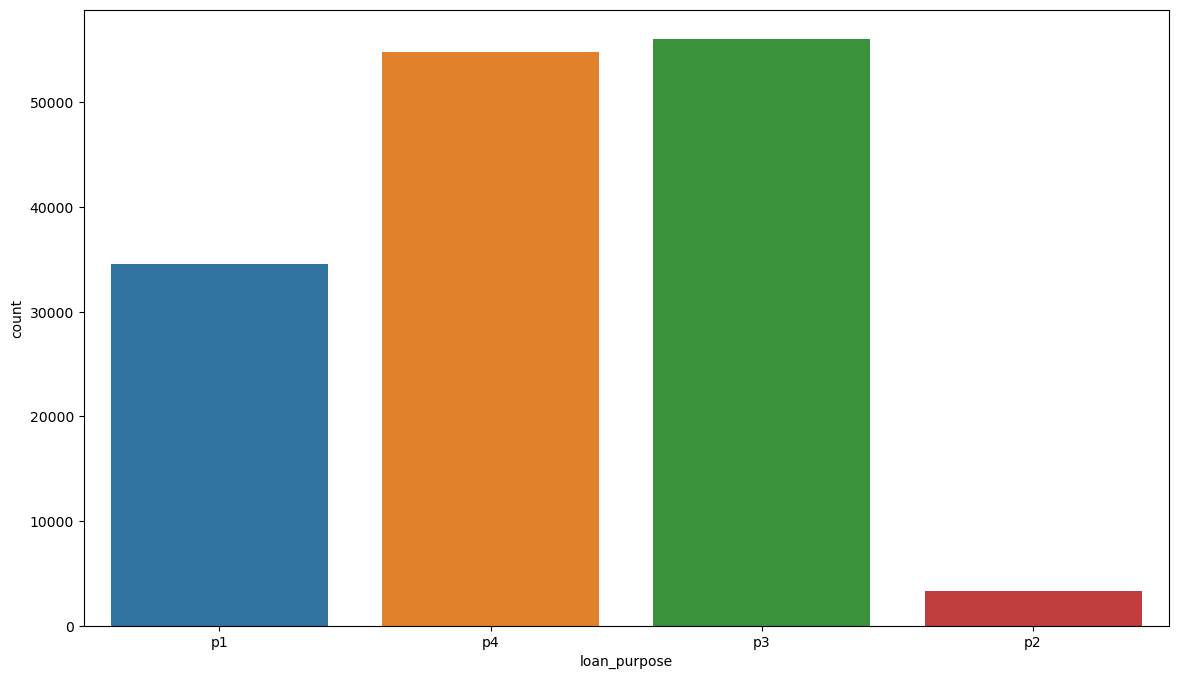

In [68]:
sns.countplot(x='loan_purpose',data=df)

<AxesSubplot:xlabel='loan_purpose', ylabel='loan_amount'>

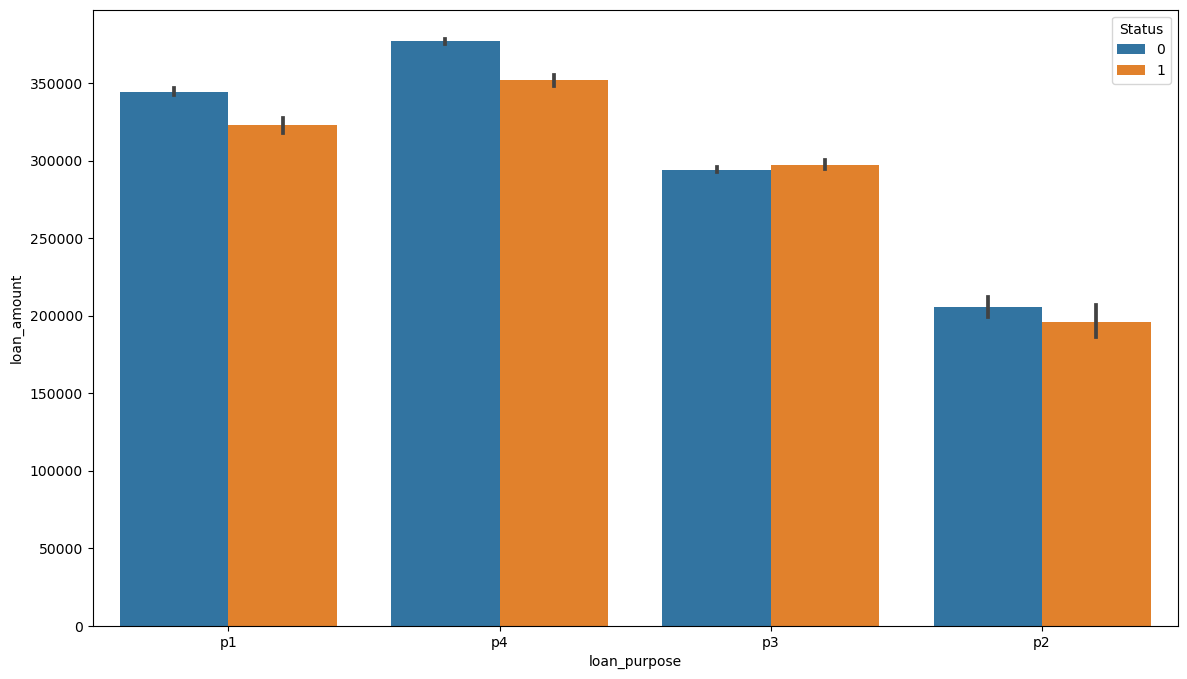

In [67]:
sns.barplot(x='loan_purpose',y='loan_amount',data=df,hue='Status')

In [ ]:
sns.barplot(x='loan_purpose',y='loan_amount',data=df,hue='Status')

In [69]:
df['Credit_Worthiness'].unique()

array(['l1', 'l2'], dtype=object)

<AxesSubplot:xlabel='Credit_Worthiness', ylabel='loan_amount'>

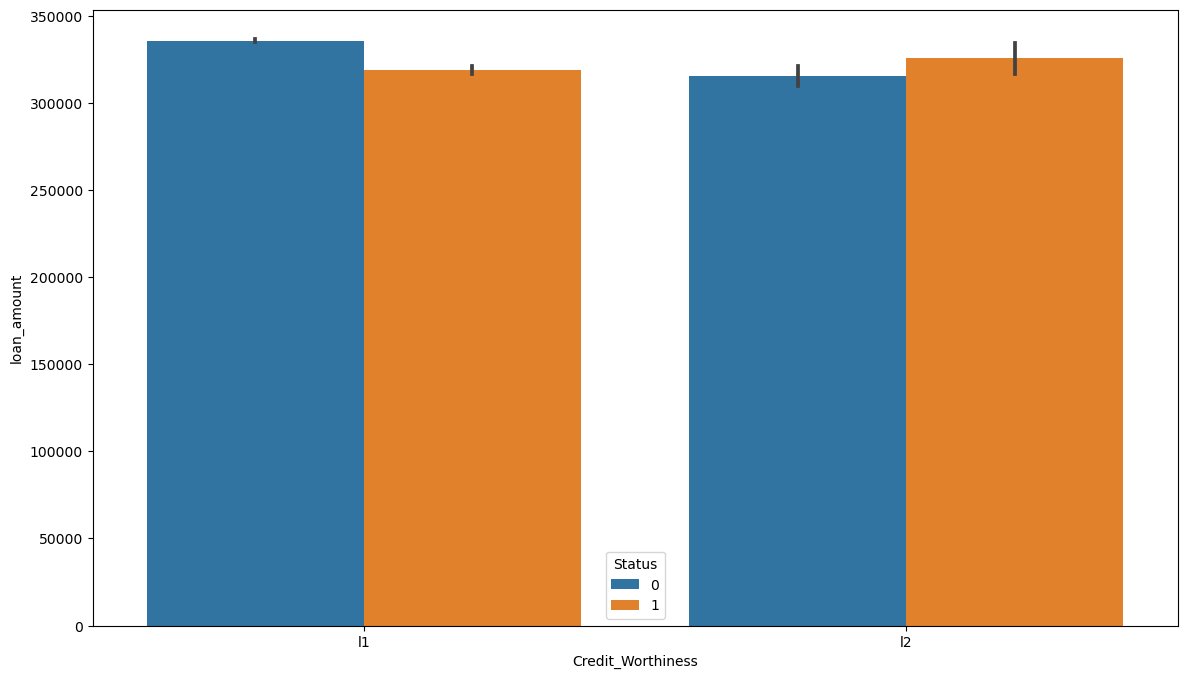

In [73]:
sns.barplot(x='Credit_Worthiness',y='loan_amount',data=df,hue='Status')

In [74]:
df['construction_type'].unique()

array(['sb', 'mh'], dtype=object)

<AxesSubplot:xlabel='construction_type', ylabel='count'>

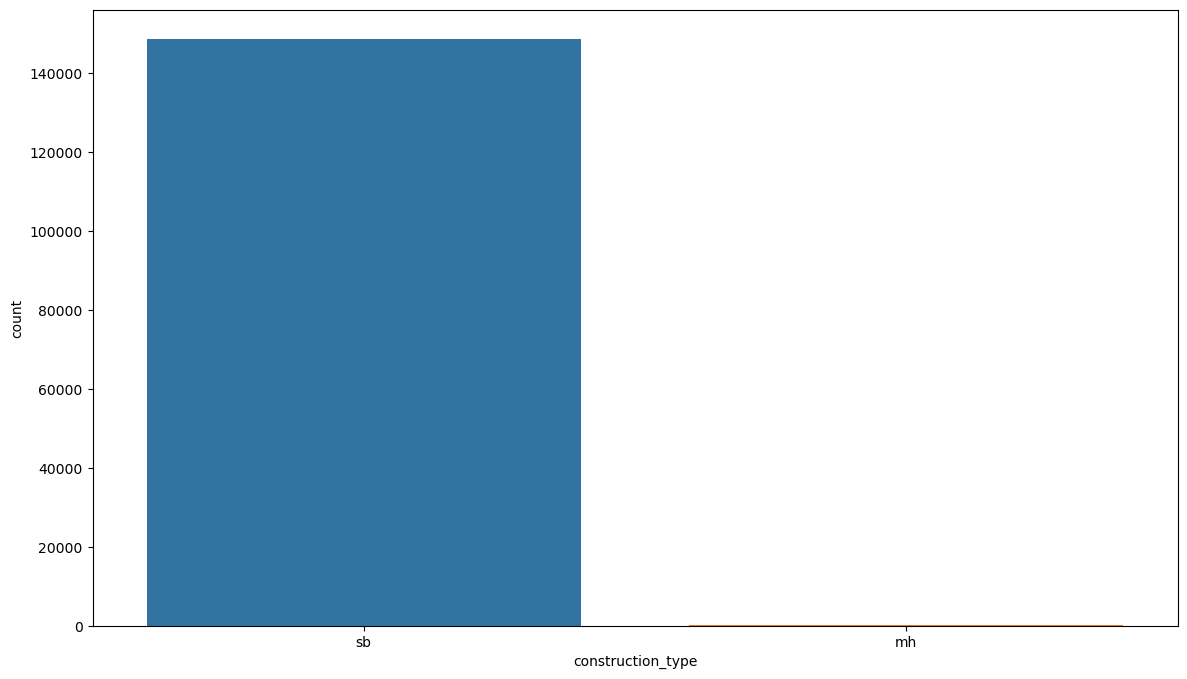

In [76]:
sns.countplot(x='construction_type',data=df)

In [77]:
df['age'].unique()

array(['25-34', '55-64', '35-44', '45-54', '65-74', '>74', '<25'],
      dtype=object)

<AxesSubplot:xlabel='age', ylabel='loan_amount'>

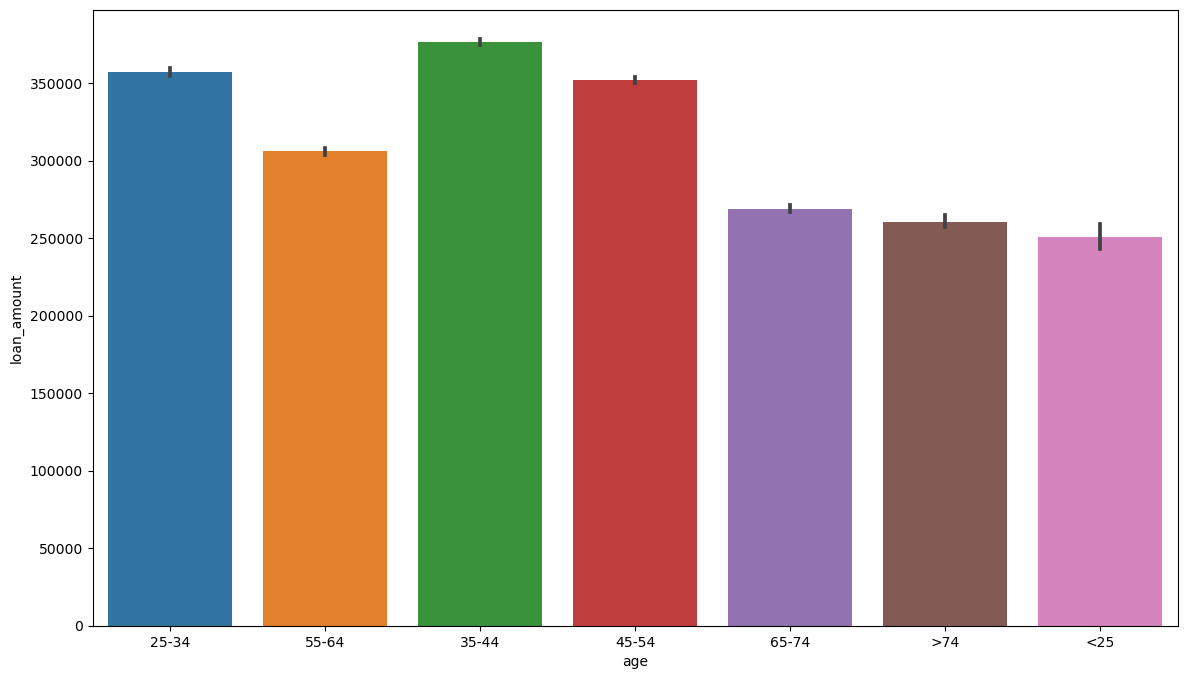

In [78]:
sns.barplot(x='age',y='loan_amount',data=df)

<AxesSubplot:xlabel='age', ylabel='count'>

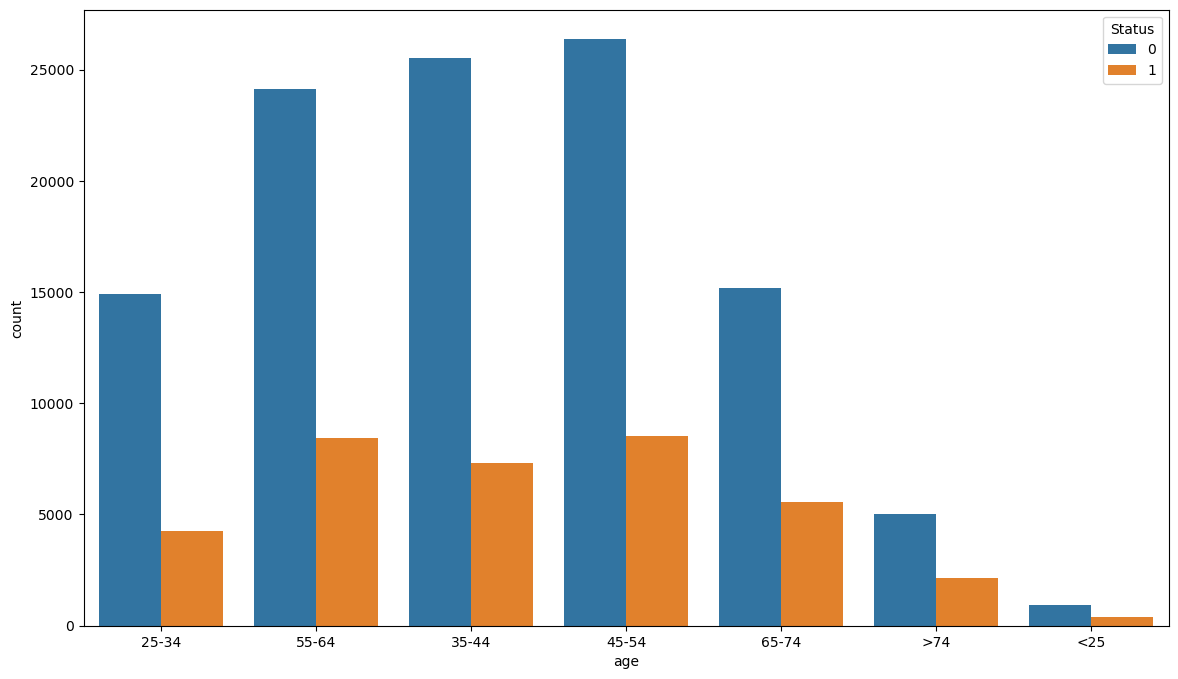

In [183]:
sns.countplot(x='age',data=df,hue ='Status')

<AxesSubplot:>

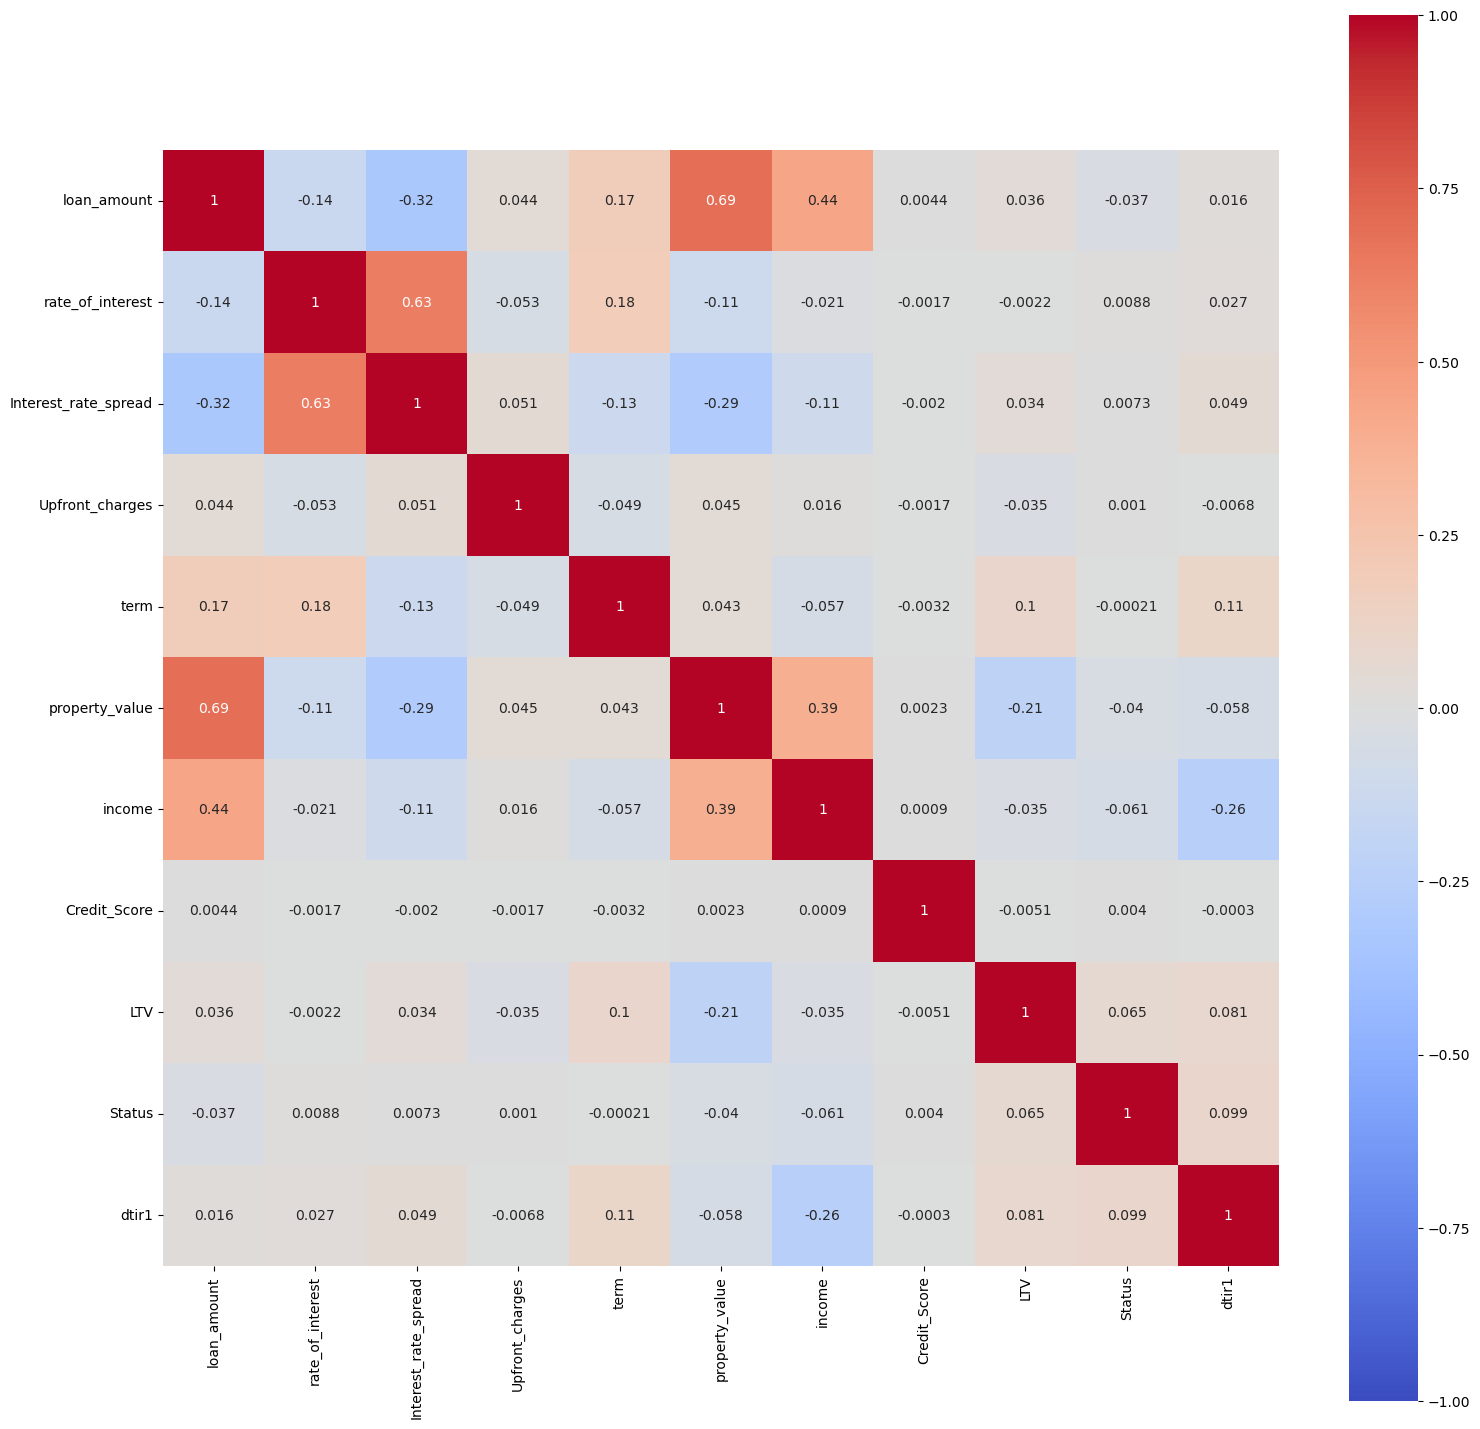

In [181]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr("pearson"),vmin=-1, vmax=1,cmap='coolwarm',annot=True, square=True)

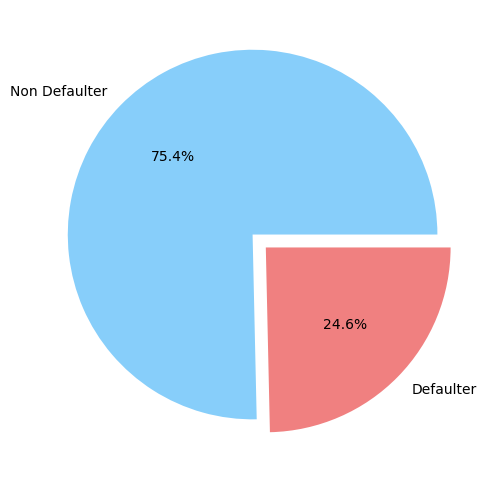

In [184]:
plt.figure(figsize=(8,6))
labels = ['Non Defaulter', 'Defaulter']
sizes = [df['Status'].value_counts()[0], df['Status'].value_counts()[1]]
colors = ['lightskyblue','lightcoral']
explode = (0.05, 0.05)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%', colors=colors, data = df);

# Modelling

In [89]:
data = pd.get_dummies(df)

In [90]:
x,y = data.drop('Status',axis=1),data.Status

In [91]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

In [92]:
x_train.shape

(118936, 69)

In [93]:
sca = MinMaxScaler()
x_train_scaled = sca.fit_transform(x_train)
x_test_scaled = sca.transform(x_test)

In [94]:
y_train.value_counts()/len(y_train)

0    0.753195
1    0.246805
Name: Status, dtype: float64

In [95]:
## Class Weight Mode
compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)

array([0.66383872, 2.02589085])

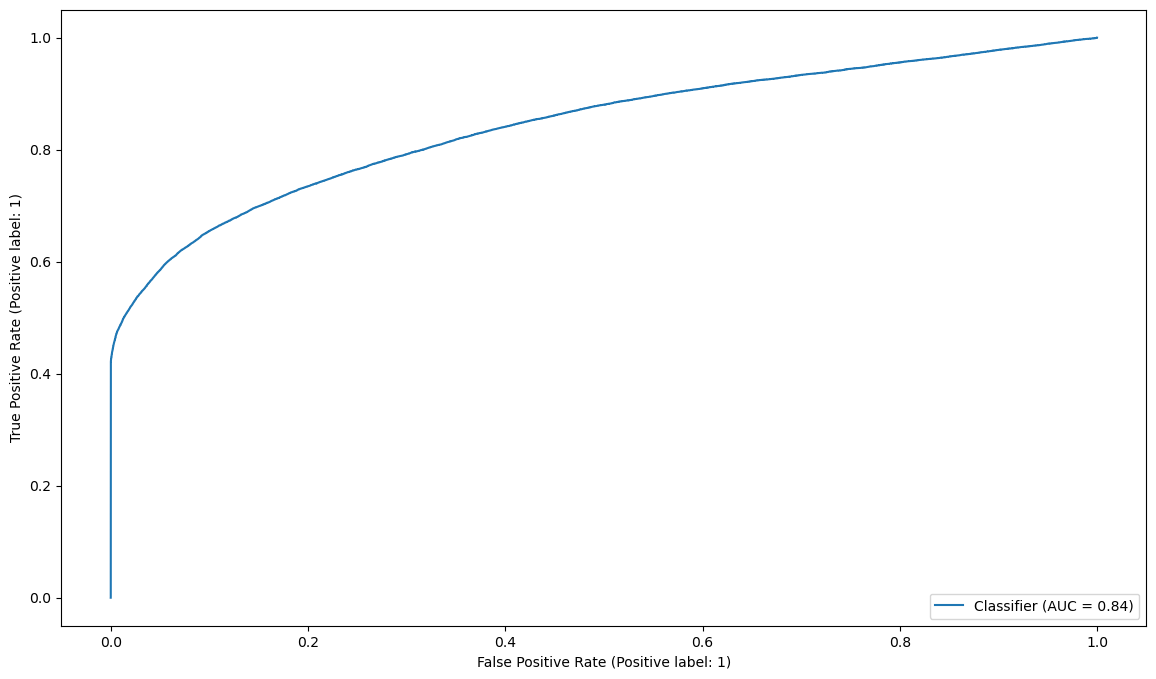

In [99]:
model = LogisticRegression(class_weight={0:0.66,1:2.02},penalty ='none',max_iter=2000)
model.fit(x_train_scaled,y_train)
train_proba = model.predict_proba(x_train_scaled)[:,1]
RocCurveDisplay.from_predictions(y_train,train_proba)

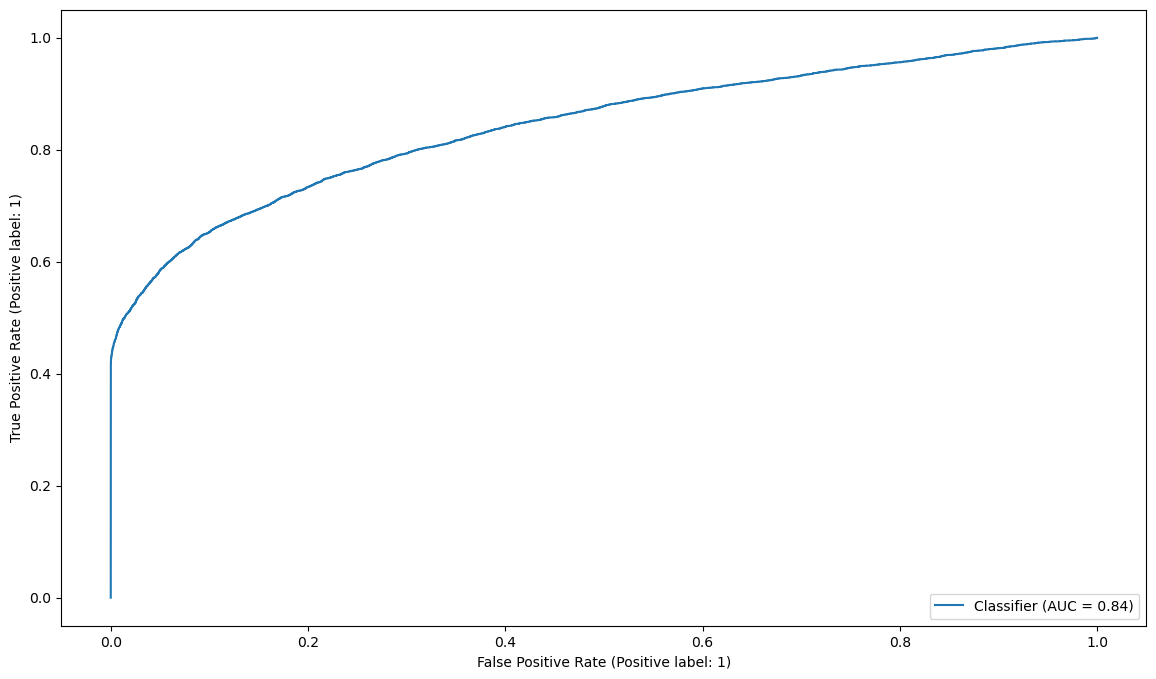

In [100]:
test_proba = model.predict_proba(x_test_scaled)[:,1]
RocCurveDisplay.from_predictions(y_test,test_proba)

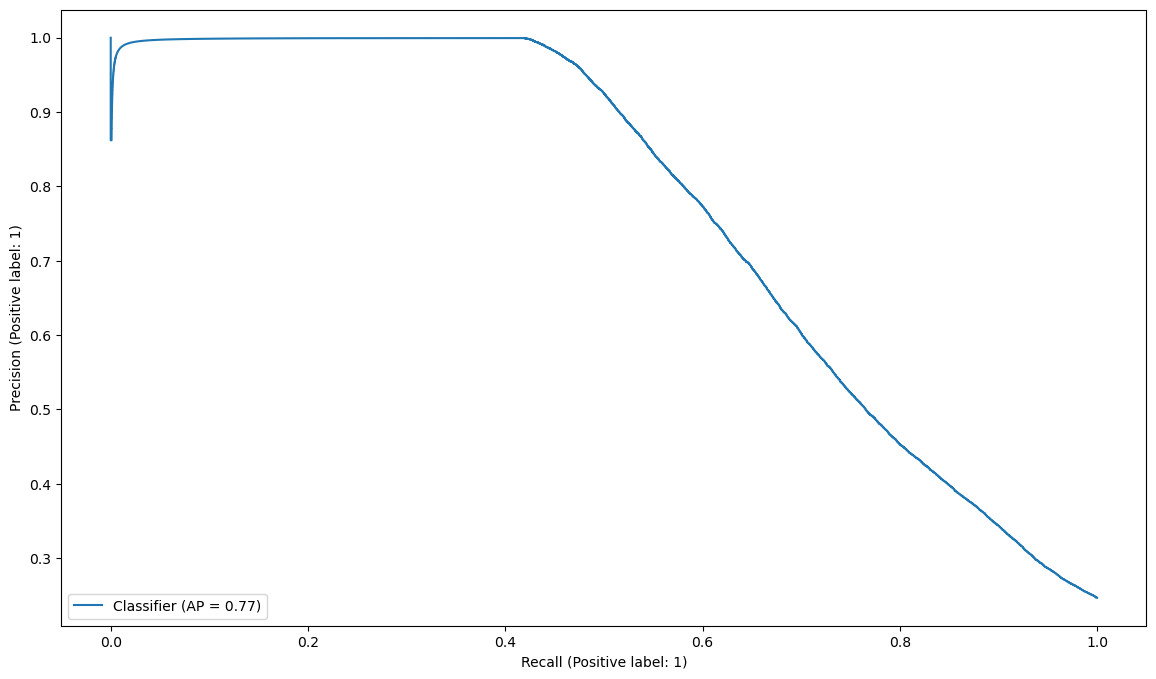

In [101]:
PrecisionRecallDisplay.from_predictions(y_train,train_proba)

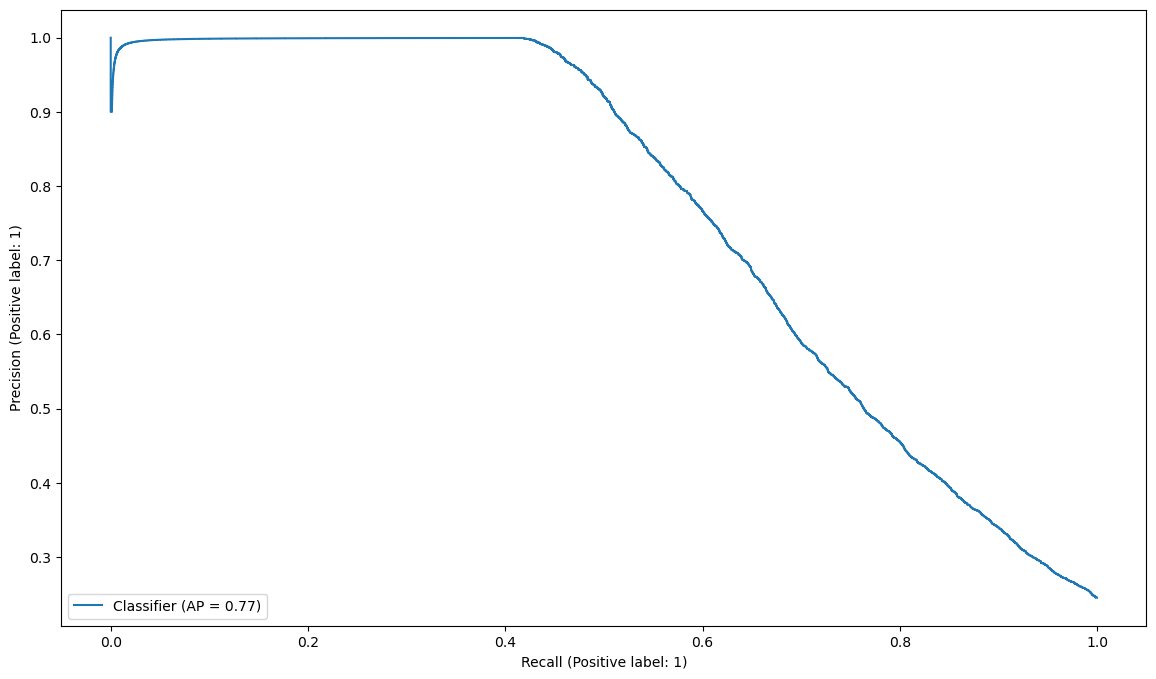

In [102]:
PrecisionRecallDisplay.from_predictions(y_test,test_proba)

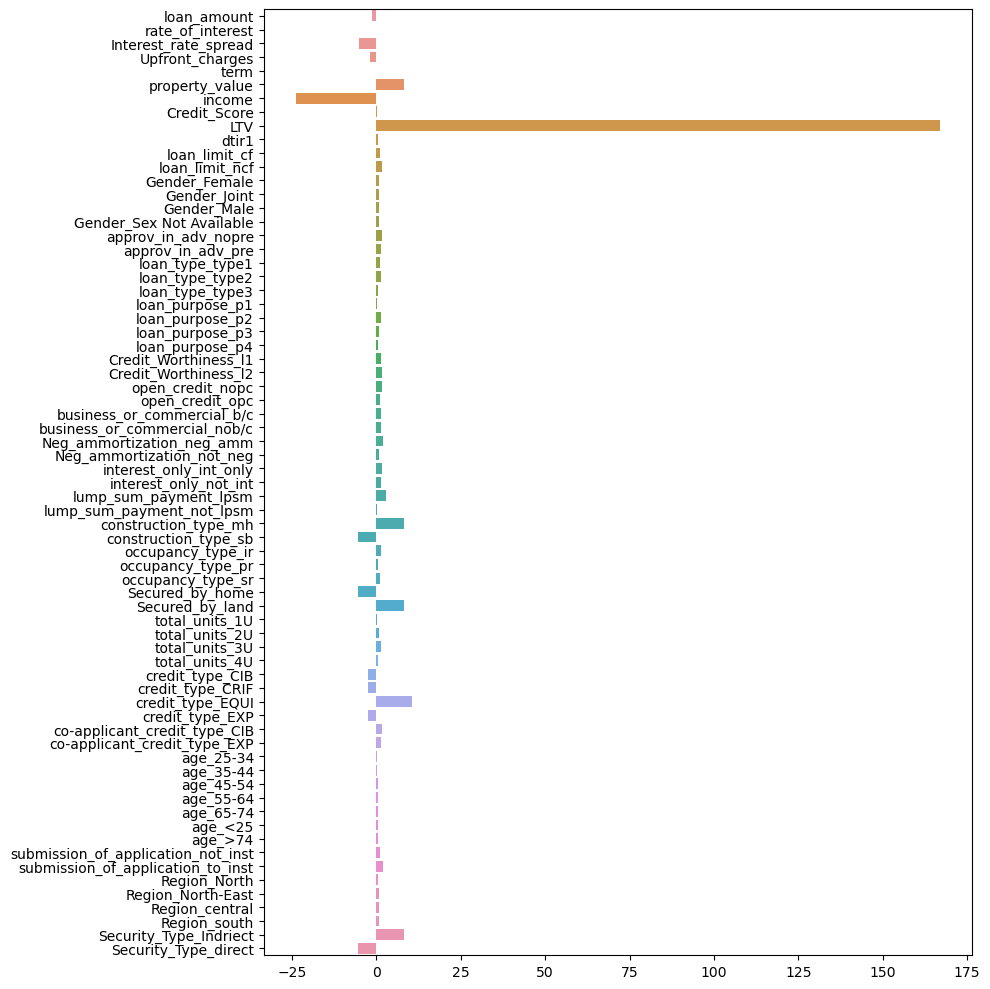

In [104]:
## Under Feature Importance
plt.figure(figsize=(10,10))
sns.barplot(y=x_train.columns,x=model.coef_[0])
plt.tight_layout()

In [105]:
    ### Feature Selection
    feat_imp = pd.DataFrame(zip(x_train.columns,model.coef_[0]),columns = ['Feature','Importance'])
    feat_imp.sort_values('Importance')

Feature  Importance
6                   income  -23.831026
68    Security_Type_direct   -5.296424
42         Secured_by_home   -5.296424
38    construction_type_sb   -5.296424
2     Interest_rate_spread   -5.079505
..                     ...         ...
67  Security_Type_Indriect    8.142166
43         Secured_by_land    8.142166
37    construction_type_mh    8.142166
50        credit_type_EQUI   10.405988
8                      LTV  166.950620

[69 rows x 2 columns]

In [103]:
p,r,th = precision_recall_curve(y_train,train_proba)

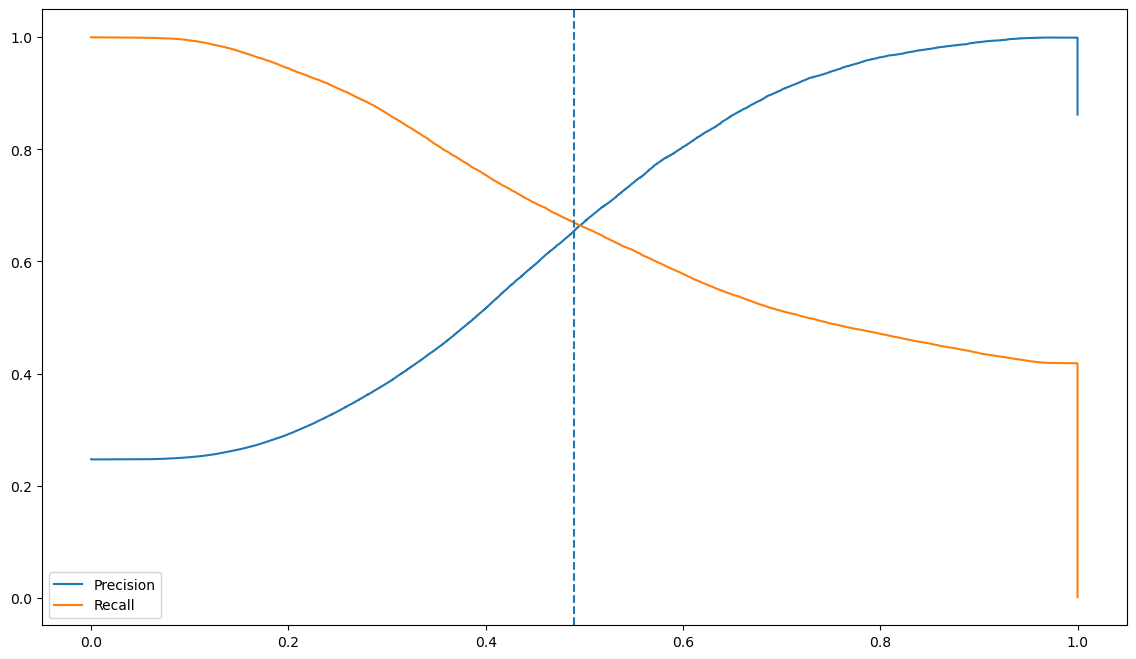

In [108]:
sns.lineplot(x=th,y=p[:-1],label='Precision')
sns.lineplot(x=th,y=r[:-1],label='Recall')
plt.axvline(0.49,linestyle='--')


In [110]:
thres = 0.49
train_pred = np.where(train_proba > thres,1,0)
test_pred= np.where(test_proba > thres,1,0)

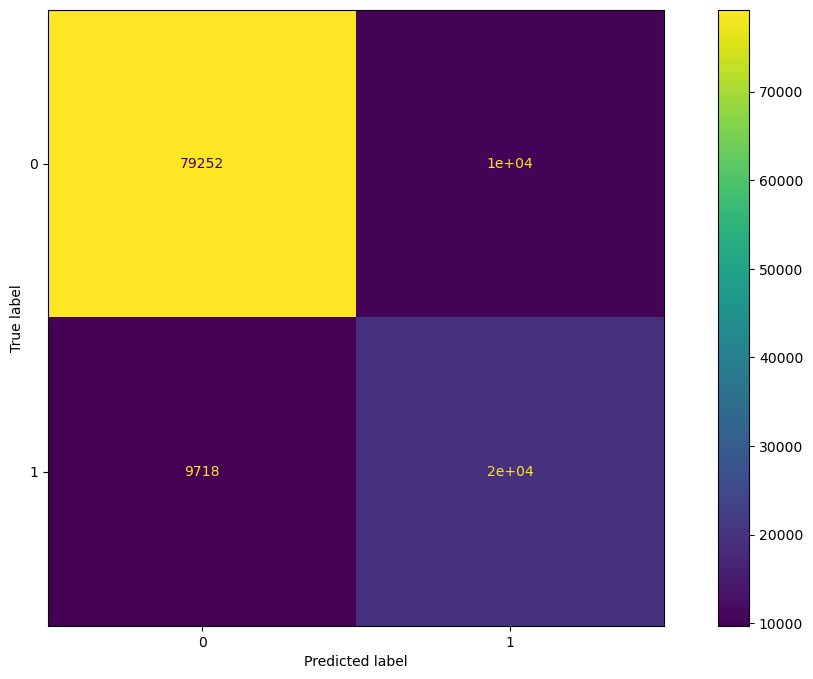

In [111]:
## Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_train,train_pred)

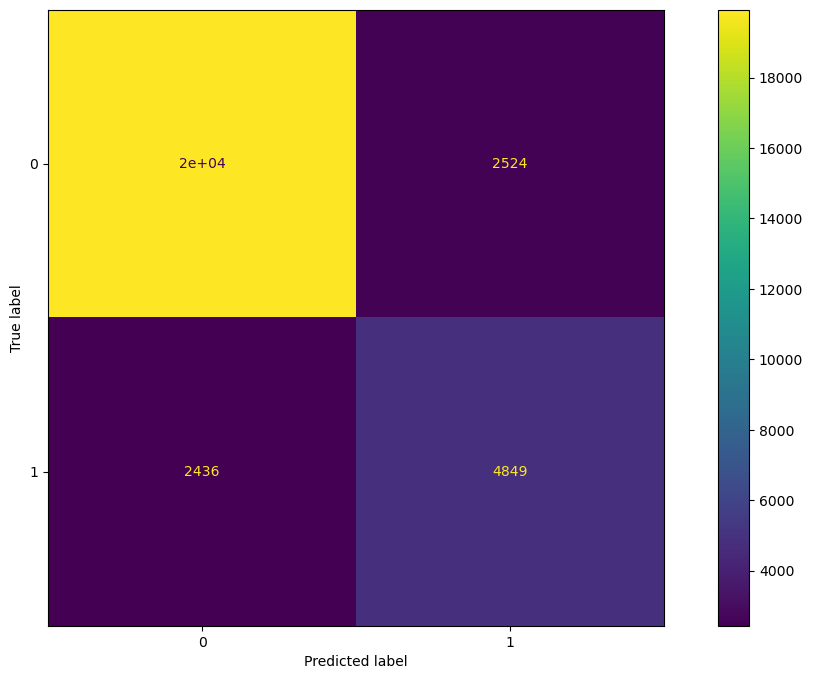

In [112]:
ConfusionMatrixDisplay.from_predictions(y_test,test_pred)

In [113]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     22449
           1       0.66      0.67      0.66      7285

    accuracy                           0.83     29734
   macro avg       0.77      0.78      0.78     29734
weighted avg       0.83      0.83      0.83     29734



In [114]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     89582
           1       0.66      0.67      0.66     29354

    accuracy                           0.83    118936
   macro avg       0.77      0.78      0.77    118936
weighted avg       0.83      0.83      0.83    118936



In [153]:
w={0:0.66,1:2.02}

In [154]:
model = DecisionTreeClassifier(class_weight=w)
model.fit(x_train_scaled,y_train)

DecisionTreeClassifier(class_weight={0: 0.66, 1: 2.02})

In [155]:
train_pred = model.predict(x_train_scaled)
test_pred = model.predict(x_test_scaled)

In [156]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22449
           1       1.00      1.00      1.00      7285

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



In [157]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89582
           1       1.00      1.00      1.00     29354

    accuracy                           1.00    118936
   macro avg       1.00      1.00      1.00    118936
weighted avg       1.00      1.00      1.00    118936



In [158]:
model.get_depth()

10

In [192]:
##parameter tuning of Decision Tree

params = {}
params["max_depth"] = list(range(1,11))
grid_reg= GridSearchCV(DecisionTreeClassifier(class_weight=w),param_grid=params,cv=5,scoring='f1_macro')

In [193]:
grid_reg.fit(x_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 0.66, 1: 2.02}),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1_macro')

In [187]:
grid_reg.best_estimator_

DecisionTreeClassifier(max_depth=10)

In [188]:
model = grid_reg.best_estimator_

In [189]:
train_pred = model.predict(x_train_scaled)
test_pred = model.predict(x_test_scaled)

In [190]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     89582
           1       1.00      1.00      1.00     29354

    accuracy                           1.00    118936
   macro avg       1.00      1.00      1.00    118936
weighted avg       1.00      1.00      1.00    118936



In [191]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22449
           1       1.00      1.00      1.00      7285

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



In [166]:
## Random Forest

In [167]:
# 1. Define an objective function to be maximized.
def objective(trial):
    n_estimator = trial.suggest_int('n_estimator',1,1000)
    max_depth = trial.suggest_int('max_depth',1,10)
    criteria = trial.suggest_categorical('criteria',['gini','entropy'])
    
    model = RandomForestClassifier(n_estimators=n_estimator,max_depth=max_depth,criterion=criteria,
                                  class_weight=w)
    
    cvs = cross_val_score(model,x_train_scaled,y_train,cv=5,scoring='f1_macro')
    return np.mean(cvs)

In [168]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-03-21 00:51:28,891] A new study created in memory with name: no-name-1c6f8c38-0f9d-45b3-9d5f-28b23041c757
[I 2023-03-21 00:54:26,831] Trial 0 finished with value: 0.9099176276587357 and parameters: {'n_estimator': 469, 'max_depth': 3, 'criteria': 'entropy'}. Best is trial 0 with value: 0.9099176276587357.
[I 2023-03-21 01:03:31,910] Trial 1 finished with value: 0.970027237111017 and parameters: {'n_estimator': 975, 'max_depth': 7, 'criteria': 'entropy'}. Best is trial 1 with value: 0.970027237111017.
[I 2023-03-21 01:05:13,892] Trial 2 finished with value: 0.7959737621674865 and parameters: {'n_estimator': 634, 'max_depth': 1, 'criteria': 'entropy'}. Best is trial 1 with value: 0.970027237111017.
[I 2023-03-21 01:07:07,863] Trial 3 finished with value: 0.7923879099284385 and parameters: {'n_estimator': 711, 'max_depth': 1, 'criteria': 'entropy'}. Best is trial 1 with value: 0.970027237111017.
[I 2023-03-21 01:09:24,333] Trial 4 finished with value: 0.9806239846805649 and parame

In [169]:
study.best_params

{'n_estimator': 226, 'max_depth': 9, 'criteria': 'gini'}

In [170]:
study.best_value

0.9806239846805649

In [171]:
optuna.visualization.plot_param_importances(study)

In [172]:
optuna.visualization.plot_optimization_history(study)

In [173]:
optuna.visualization.plot_parallel_coordinate(study)

In [174]:
study.best_params

{'n_estimator': 226, 'max_depth': 9, 'criteria': 'gini'}

In [175]:
model = RandomForestClassifier(n_estimators=226,max_depth=9,criterion='gini',class_weight=w)

In [176]:
model.fit(x_train_scaled,y_train)

RandomForestClassifier(class_weight={0: 0.66, 1: 2.02}, max_depth=9,
                       n_estimators=226)

In [177]:
print(classification_report(y_train,model.predict(x_train_scaled)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     89582
           1       0.94      1.00      0.97     29354

    accuracy                           0.98    118936
   macro avg       0.97      0.99      0.98    118936
weighted avg       0.99      0.98      0.98    118936



In [178]:
print(classification_report(y_test,model.predict(x_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22449
           1       0.94      1.00      0.97      7285

    accuracy                           0.98     29734
   macro avg       0.97      0.99      0.98     29734
weighted avg       0.98      0.98      0.98     29734



# Score Card

In [129]:
## Higher Value represent High Credit worthiness
train_proba = 1- train_proba
test_proba = 1 - test_proba

In [179]:
temp = pd.DataFrame(zip(y_train,train_proba),columns = ['Actual','Score'])
temp['Score-Group'] = pd.qcut(temp['Score'],q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],labels=['0-10','11-20','21-30','31-40','41-50','51-60',
                                                                         '61-70','71-80','81-90','91-100'])

temp = temp.groupby(['Score-Group']).agg({'Actual':['count','sum']})
temp.columns = ['total_obs','defaulter']
temp['non_defaulter'] = temp.total_obs - temp.defaulter
temp['%default'] = (temp.defaulter *100 / temp.total_obs).round(2)
temp['% Overall Default'] = (temp.defaulter*100/(temp.defaulter.sum())).round(2)
temp['%Cum_default'] = temp['% Overall Default'].cumsum().round(0)
temp

total_obs  defaulter  non_defaulter  %default  % Overall Default  \
Score-Group                                                                     
0-10             11894        812          11082      6.83               2.77   
11-20            11894        806          11088      6.78               2.75   
21-30            11893        801          11092      6.74               2.73   
31-40            11894       1023          10871      8.60               3.49   
41-50            11893       1349          10544     11.34               4.60   
51-60            11894       1688          10206     14.19               5.75   
61-70            11893       2019           9874     16.98               6.88   
71-80            11894       2931           8963     24.64               9.99   
81-90            11893       6036           5857     50.75              20.56   
91-100           11894      11889              5     99.96              40.50   

             %Cum_default  
Score-Group                
0-10                  3.0  
11-20                 6.0  
21-30                 8.0  
31-40                12.0  
41-50                16.0  
51-60                22.0  
61-70                29.0  
71-80                39.0  
81-90                60.0  
91-100              100.0

In [180]:
temp = pd.DataFrame(zip(y_test,test_proba),columns = ['Actual','Score'])
temp['Score-Group'] = pd.qcut(temp['Score'],q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],labels=['0-10','11-20','21-30','31-40','41-50','51-60',
                                                                         '61-70','71-80','81-90','91-100'])

temp = temp.groupby(['Score-Group']).agg({'Actual':['count','sum']})
temp.columns = ['total_obs','defaulter']
temp['non_defaulter'] = temp.total_obs - temp.defaulter
temp['%default'] = (temp.defaulter *100 / temp.total_obs).round(2)
temp['% Overall Default'] = (temp.defaulter*100/(temp.defaulter.sum())).round(2)
temp['%Cum_default'] = temp['% Overall Default'].cumsum().round(0)
temp

total_obs  defaulter  non_defaulter  %default  % Overall Default  \
Score-Group                                                                     
0-10              2974        172           2802      5.78               2.36   
11-20             2973        214           2759      7.20               2.94   
21-30             2973        227           2746      7.64               3.12   
31-40             2974        249           2725      8.37               3.42   
41-50             2973        325           2648     10.93               4.46   
51-60             2973        405           2568     13.62               5.56   
61-70             2974        534           2440     17.96               7.33   
71-80             2973        705           2268     23.71               9.68   
81-90             2973       1481           1492     49.82              20.33   
91-100            2974       2973              1     99.97              40.81   

             %Cum_default  
Score-Group                
0-10                  2.0  
11-20                 5.0  
21-30                 8.0  
31-40                12.0  
41-50                16.0  
51-60                22.0  
61-70                29.0  
71-80                39.0  
81-90                59.0  
91-100              100.0